In [29]:
import requests
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from adjustText import adjust_text

In [ ]:
countries = ["Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Lithuania",
             "Luxembourg", "Malta", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Republic of Turkiye", "Romania", "Serbia", "Slovak Republic", "Slovenia", "Spain", "Sweden", "Serbia", "Switzerland", "United Kingdom"]

# countries = ['Romania']

data_net_electricity_production = {}
data_renewables_production = {}


def call_api_extract_electricity(country, month, product):
    while True:
        request = requests.get(f'https://api.iea.org/mes/latest/month?COUNTRY={country}&YEAR=2022&MONTH={month}&PRODUCT={product}', verify=False)
        if request.status_code == 200:
            response_json = json.loads(request.text)
            value = response_json['latest'][0]['VALUE']
            return value


for country in countries:
    country_net_electricity_production = []
    country_renewables_production = []
    for month in range(1, 13):
        net_electricity_production = call_api_extract_electricity(country, month, 'Net electricity production')
        renewables_production = call_api_extract_electricity(country, month, 'Renewables')
        
        country_net_electricity_production.append(net_electricity_production)
        country_renewables_production.append(renewables_production)

    data_net_electricity_production[country] = country_net_electricity_production
    data_renewables_production[country] = country_renewables_production

df_net_elec_prod = pd.DataFrame(data_net_electricity_production)
df_renew_prod = pd.DataFrame(data_renewables_production)

path_net_prod = './iea_data_net_electricity_production.xlsx'
path_renew = './iea_data_renewables_production.xlsx'

df_net_elec_prod.to_excel(path_net_prod)
df_renew_prod.to_excel(path_renew)

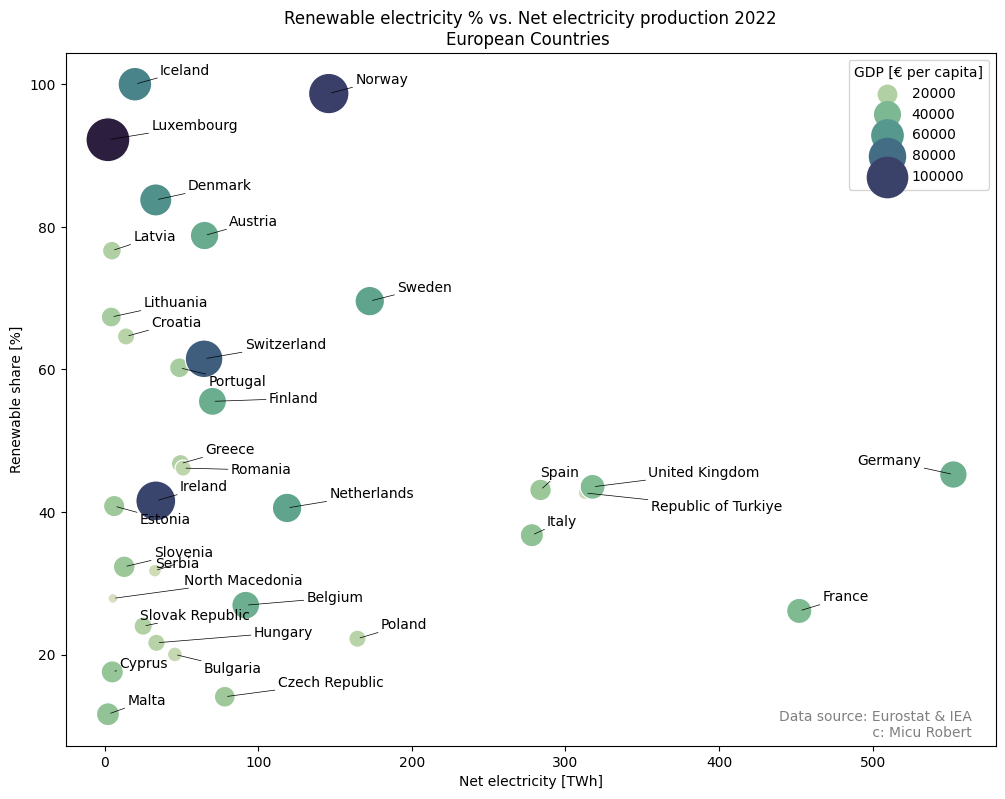

In [72]:
df_net_elec_prod = pd.read_excel('./iea_data_net_electricity_production.xlsx', index_col=0)
df_renew_prod = pd.read_excel('./iea_data_renewables_production.xlsx', index_col=0)

df_net_elec_prod = df_net_elec_prod/1000
df_renew_prod = df_renew_prod/1000

df_net_elec_prod.loc[13] = df_net_elec_prod.sum()
df_renew_prod.loc[13] = df_renew_prod.sum()

df_renew_share = df_renew_prod.iloc[12]/(df_net_elec_prod.iloc[12]/100)

df_full_data = pd.concat([df_net_elec_prod.iloc[12], df_renew_prod.iloc[12], df_renew_share], axis=1).reset_index()
df_full_data.columns = ['Country', 'Net electricity [TWh]', 'Net renewable [TWh]', 'Renewable share [%]']

df_gpd = pd.read_excel('./tec00001_page_spreadsheet.xlsx')

df_full_data = pd.merge(df_full_data, df_gpd.loc[:, ['Country', '2022']], on='Country', how='left')
df_full_data.rename(columns={'2022' : 'GDP [€ per capita]'}, inplace=True)

def scale(x, lower=0, upper=1):
    return ((x - np.min(x)) / (np.max(x) - np.min(x))) * (upper - lower)  + lower

alpha = scale(df_full_data['GDP [€ per capita]'], 0.1, 1)

fig, ax = plt.subplots(figsize=(12,9))

ax = sns.scatterplot(data=df_full_data, x="Net electricity [TWh]", y="Renewable share [%]", size='GDP [€ per capita]', hue='GDP [€ per capita]', palette=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True), sizes=(50, 1000), legend='brief')

ax.set_title('Renewable electricity % vs. Net electricity production 2022\nEuropean Countries ')

fig.text(0.88, 0.12, 'Data source: Eurostat & IEA\n c: Micu Robert', horizontalalignment='right', fontsize=10, color='gray')

texts = []
for i in range(df_full_data.shape[0]):
    x = df_full_data['Net electricity [TWh]'].iloc[i]
    y = df_full_data['Renewable share [%]'].iloc[i]
    text = df_full_data['Country'].iloc[i]
    if i == 27:
        adjust_text(
            [ax.text(x, y, text, fontsize=10)], 
            expand_points=(1, 1),
            arrowprops=dict(arrowstyle="-", lw=0.5),
            ax=ax
        )
    else:
        texts.append(ax.text(x, y, text, fontsize=10))

adjust_text(
    texts, 
    expand_points=(2, 2),
    arrowprops=dict(arrowstyle="-", lw=0.5),
    ax=ax
)

fig.savefig('gdp_renewable_energy_vs_net_production')